# Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond

이 iPython noteboon 에서 Double DQN 과 Dueling DQN 둘다 사용해서 Deep Q-Network를 구현한다. 이 에이전트는 기본적인 격자 세계에서 네비게이션 작업을 해결하는 것을 배운다.

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

# 게임 환경 불러오기

격자세계의 크기를 조절할 수 있다. 크기를 더 작게 하면 우리의 DQN 에이전트가 쉽게 작업할 수 있지만, 크게하면 도전과제가 된다.

gridworld 모듈은 https://github.com/awjuliani/DeepRL-Agents/blob/master/gridworld.py 에서 받을 수 있다.

In [2]:
tf.__version__

'1.1.0'

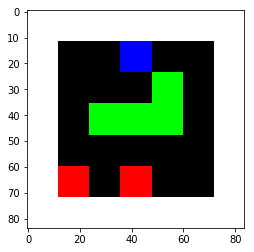

In [3]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=5)

위에는 우리의 단순한 게임에서 출발 환경의 예이다. 에이전트는 파란색 사각형을 조정하고, 위, 아래, 왼쪽, 오른쪽으로 움직일 수 있다. 목표는 초록색 사각형(보상 +1)로 움직이고, 빨간색 사각형(보상 -1)을 피하는 것이다. 이 세 블록의 위치는 매 에피소드 마다 무작위이다.

# 신경망 구현하기

In [4]:
# 신경망 구현
class Qnetwork():
    def __init__(self,h_size):
        # 신경망은 게임으로부터 벡터화된 배열로 프레임을 받아서 
        # 이것을 리사이즈 하고, 4개의 콘볼루션 레이어를 통해 처리한다.
        
        # 입력값을 받는 부분 21168 차원은 84*84*3 의 차원이다.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        # conv2d 처리를 위해 84x84x3 으로 다시 리사이즈
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        
        # 첫번째 콘볼루션은 8x8 커널을 4 스트라이드로 32개의 activation map을 만든다
        # 출력 크기는 (image 크기 - 필터 크기) / 스트라이드 + 1 이다.
        # zero padding이 없는 VALID 옵션이기 때문에
        # (84-8)/4 + 1
        # 20x20x32 의 activation volumn이 나온다
        self.conv1 = tf.contrib.layers.convolution2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        # 두번째 콘볼루션은 4x4 커널을 2 스트라이드로 64개의 activation map을 만든다.
        # 출력 크기는 9x9x64
        self.conv2 = tf.contrib.layers.convolution2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        # 세번째 콘볼루션은 3x3 커널을 1 스트라이드로 64개의 activation map을 만든다.
        # 출력 크기는 7x7x64
        self.conv3 = tf.contrib.layers.convolution2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        # 네번째 콘볼루션은 7x7 커널을 1 스트라이드 512개의 activation map을 만든다.
        # 출력 크기는 1x1x512
        self.conv4 = tf.contrib.layers.convolution2d( \
            inputs=self.conv3,num_outputs=512,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        # 마지막 콘볼루션 레이어의 출력을 가지고 2로 나눈다.
        # streamAC, streamVC 는 각각 1x1x256
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        # 이를 벡터화한다. streamA 와 streamV는 256 차원씩이다.
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        # 256개의 노드를 곱해서 각각 A와 V를 구하는 가중치
        self.AW = tf.Variable(tf.random_normal([256,env.actions]))
        self.VW = tf.Variable(tf.random_normal([256,1]))
        # 점수화 한다.
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        # 가치 함수 값에 이득에서 이득의 평균을 빼준 값들을 더해준다.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,reduction_indices=1,keep_dims=True))
        # 이것으로 행동을 고른다.
        self.predict = tf.argmax(self.Qout,1)
        
        # 타겟과 예측 Q value 사이의 차이의 제곱합이 손실이다.
        # 타겟Q를 받는 부분
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        # 행동을 받는 부분
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        # 행동을 one_hot 인코딩 하는 부분 (tf.one_hot은 내 컴퓨터에서 GPU 에러를 내기에 다음의 해법을 찾아 적용)
        def one_hot_patch(x,depth):
            sparse_labels=tf.reshape(x,[-1,1])
            derived_size=tf.shape(sparse_labels)[0]
            indices=tf.reshape(tf.range(0,derived_size,1),[-1,1])
            concated=tf.concat([indices,sparse_labels],1)
            outshape=tf.concat([tf.reshape(derived_size,[1]),tf.reshape(depth,[1])],0)
            return tf.sparse_to_dense(concated, outshape,1.0,0.0)
        self.actions_onehot = one_hot_patch(self.actions,env.actions)
        
        # 각 네트워크의 행동의 Q 값을 골라내는 것
        # action 번째를 뽑고 싶지만 tensor는 인덱스로 쓸 수 없어서 이렇게 하는듯(내 생각)
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), reduction_indices=1)
        
        # 각각의 차이
        self.td_error = tf.square(self.targetQ - self.Q)
        # 손실
        self.loss = tf.reduce_mean(self.td_error)
        # 최적화 방법 adam
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        # 업데이트 함수
        self.updateModel = self.trainer.minimize(self.loss)

# Experience Replay

이 클래스는 경험을 저장하고 샘플을 뽑아 신경망에 랜덤하게 보내진다.

In [5]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    # 더할 때 버퍼사이즈를 넘으면, 앞에서부터 지우고 다시 넣는다.
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
    # 
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

우리의 게임 프레임들을 리사이즈 해주는 단순한 함수

In [6]:
def processState(states):
    return np.reshape(states,[21168])

이 함수들은 주요 신경망과 함께 타겟 신경망의 파라미터들을 업데이트 할 수 있다.

In [7]:
def updateTargetGraph(tfVars,tau):
    # tfVars 는 학습 가능한 변수들
    # tau는 타겟 신경망이 학습 신경망을 향하는 비율
    # 학습 가능한 변수들의 수
    total_vars = len(tfVars)
    
    # 연산자 저장 리스트
    op_holder = []
    # 학습 가능한 변수의 절반은 주요 신경망, 절반은 타겟 신경망
    for idx,var in enumerate(tfVars[0:int(total_vars/2)]):
        # 앞의 절반의 값에 tau 값을 곱하면, 주요 신경망의 weight에 곱해지고
        # 뒤의 절반의 값에 1-tau 값을 곱하면, 타겟 신경망의 weight에 곱해져서
        # 이부분 타겟 신경망을 업데이트하는 부분
        op_holder.append(tfVars[int(idx)+int(total_vars/2)].assign((var.value()*tau) 
                                                                   + ((1-tau)*tfVars[int(idx)+int(total_vars/2)].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

# Training the network
학습 파라미터들 설정하기

In [ ]:
batch_size = 32 # 각 학습 단계에 대해 얼마나 많은 경험을 사용할지 결정
update_freq = 4 # 학습 단계를 얼마나 자주 수행할 것인가
y = .99 # 타겟 Q 값에 대한 할인 인자
startE = 1 # 무작위 행위의 시작 확률
endE = 0.1 # 무작위 행위의 최종 확률
anneling_steps = 10000. # startE부터 endE까지 몇단계에 걸쳐서 줄일 것인가.
num_episodes = 10000 # 몇개의 에피소드를 할 것인가.
pre_train_steps = 10000 # 학습 시작 전에 몇번의 무작위 행위를 할 것인가.
max_epLength = 50 # 에피소드의 최대 길이 (50 걸음)
load_model = False # 저장된 모델을 불러올 것인가?
path = "./dqn" # 모델을 저장할 위치
h_size = 512 # 이득 함수와 가치 함수로 나뉘기 전에 최종 콘볼루션의 크기
tau = 0.001 # 주요 신경망을 향해 타겟 신경망이 업데이트되는 비율

In [ ]:
# 그래프를 초기화한다
tf.reset_default_graph()
# 주요 신경망을 만든다
mainQN = Qnetwork(h_size)
# 타겟 신경망을 만든다.
targetQN = Qnetwork(h_size)

# 변수들을 초기화한다
init = tf.global_variables_initializer()

# saver를 만든다
saver = tf.train.Saver()

# 학습가능한 변수를 꺼낸다
trainables = tf.trainable_variables()

# 타겟 신경망을 업데이트하기 위한 값을 만든다
targetOps = updateTargetGraph(trainables,tau)

# 경험을 저장할 장소
myBuffer = experience_buffer()

# 무작위 행위 확률을 설정한다
e = startE
# 점점 줄여나간다.
stepDrop = (startE - endE)/anneling_steps

# 에피소드별 총 보상과 걸음을 저장할 리스트를 만든다
jList = []
rList = []
total_steps = 0

# 모델을 세이브할 장소를 만든다.
if not os.path.exists(path):
    os.makedirs(path)

# 텐서플로 세션을 연다
with tf.Session() as sess:
    # 모델을 불러올지 체크
    if load_model == True:
        print ('Loading Model...')
        # 모델을 불러온다
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    # 변수를 초기화한다.
    sess.run(init)
    # 주요 신경망과 동일하게 타겟 신경망을 설정한다
    updateTarget(targetOps,sess) 
    # 에피소드 시작
    for i in range(num_episodes):
        # 에피소드별 경험 버퍼를 초기화한다
        episodeBuffer = experience_buffer()
        
        # 환경과 처음 상태을 초기화한다
        s = env.reset()
        s = processState(s)
        # 종료 여부
        d = False
        # 보상
        rAll = 0
        # 걸음
        j = 0
        # Q-Network
        # 만약 50 걸음보다 더 간다면 종료한다.
        while j < max_epLength:
            j+=1
            # Q-network 로부터 행동을 greedy 하게 선택하거나 e의 확률로 무작위 행동을 한다
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                # 신경망을 통해 Q 값을 가져오는 부분
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            
            # 주어진 행동을 실행하고 다음 상태, 보상, 종료 여부를 가져옴
            s1,r,d = env.step(a)
            # 상태를 다시 21168 차원으로 리사이즈
            s1 = processState(s1)
            # 걸음수를 늘림
            total_steps += 1
            # 버퍼에 현재 상태, 행동, 보상, 다음 상태, 종료 여부를 저장한다
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) 
            
            # 무작위 행동의 수를 넘으면 시작
            if total_steps > pre_train_steps:
                # 무작위 확률 값을 줄인다
                if e > endE:
                    e -= stepDrop
                
                # 총 걸음이 업데이트 수로 나누어 떨어지면 시작
                if total_steps % (update_freq) == 0:
                    # 경험으로부터 랜덤한 배치를 뽑는다
                    trainBatch = myBuffer.sample(batch_size) 
                    # 아래는 target Q-value를 업데이트하는 Double-DQN을 수행한다
                    # 주요 신경망에서 행동을 고른다.
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    # 타겟 신경망에서 Q 값들을 얻는다.
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    # 종료 여부에 따라 가짜 라벨을 만들어준다
                    end_multiplier = -(trainBatch[:,4] - 1)
                    # 타겟 신경망의 Q 값들 중에 주요 신경망에서 고른 행동 번째의 Q 값들을 가져온다.(이부분이 doubleQ)
                    doubleQ = Q2[range(batch_size),Q1]
                    # 보상에 대한 더블 Q 값을 더해준다. y는 할인 인자
                    # targetQ 는 즉각적인 보상 + 다음 상태의 최대 보상(doubleQ)
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    # 우리의 타겟 값들과 함께 신경망을 업데이트해준다.
                    # 행동들에 대해서 targetQ 값과의 차이를 통해 손실을 구하고 업데이트
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    # 주요 신경망과 동일하게 타겟 신경망을 설정한다.
                    # 물론 주요 신경망의 값은 tau 만큼만이 반영된다.
                    updateTarget(targetOps,sess) 
            # 총 봊상
            rAll += r
            # 상태를 바꾼다.
            s = s1
            
            # 종료가 되면 멈춘다.
            if d == True:

                break
        
        # 이 에피소드로부터의 모든 경험을 저장한다
        myBuffer.add(episodeBuffer.buffer)
        # 걸음을 저장한다.
        jList.append(j)
        # 보상을 저장한다
        rList.append(rAll)
        # 주기적으로 모델을 저장한다
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print ("Saved Model")
        # 최근 10 에피소드의 평균 보상값을 나타낸다.
        if len(rList) % 10 == 0:
            print (total_steps,np.mean(rList[-10:]), e)
    # 모델을 저장한다.
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
# 성공확률을 표시
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model
500 2.0 1
1000 3.3 1
1500 1.0 1
2000 0.3 1
2500 2.9 1
3000 2.0 1
3500 0.5 1
4000 2.3 1
4500 3.0 1
5000 1.2 1
5500 3.1 1
6000 1.9 1
6500 1.5 1
7000 1.1 1
7500 1.4 1
8000 1.9 1
8500 1.5 1
9000 1.9 1
9500 4.0 1
10000 2.6 1
10500 2.2 0.9549999999999828
11000 1.3 0.9099999999999655
11500 2.1 0.8649999999999483
12000 1.6 0.819999999999931
12500 0.0 0.7749999999999138
13000 2.2 0.7299999999998965
13500 2.9 0.6849999999998793
14000 0.9 0.639999999999862
14500 2.2 0.5949999999998448
15000 0.8 0.5499999999998275
15500 0.8 0.5049999999998103
16000 1.3 0.4599999999998177
16500 1.3 0.41499999999982823
17000 2.4 0.36999999999983874
17500 1.3 0.32499999999984924
18000 0.2 0.27999999999985975
18500 1.9 0.23499999999986562
19000 0.3 0.18999999999986225
19500 0.7 0.14499999999985888
20000 1.4 0.09999999999985551
20500 0.6 0.09999999999985551
21000 0.9 0.09999999999985551
21500 1.0 0.09999999999985551
22000 0.1 0.09999999999985551
22500 1.8 0.09999999999985551
23000 0.8 0.09999999999985551
23